# Transformer Analysis
 Using the TranformerLens and SAELens libraries we analyzed the behavior of LLaVA (fine tuned Gemma-2B) using a pre-trained SAE on Gemma-2B

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
import contextlib
import requests
import torch
import transformer_lens
import transformers
from tempfile import TemporaryDirectory
from PIL import Image

es = contextlib.ExitStack()
es.enter_context(torch.inference_mode())

model_name = "Intel/llava-gemma-2b"
model = transformers.AutoModelForImageTextToText.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)
processor = transformers.AutoProcessor.from_pretrained(model_name)
processor.patch_size = model.config.vision_config.patch_size
processor.vision_feature_select_strategy = model.config.vision_feature_select_strategy

def get_hooked_model(model, tokenizer):
    with TemporaryDirectory() as model_name:
        model.config.save_pretrained(model_name)
        cfg = transformer_lens.loading.get_pretrained_model_config(
            model_name,
            device=model.device,
            dtype=model.dtype,
        )
        state_dict = transformer_lens.loading.get_pretrained_state_dict(
            model_name,
            cfg,
            model,
        )
        for k, v in state_dict.items():
            if v.device != model.device:
                state_dict[k] = v.to(model.device)
    hooked_model = transformer_lens.HookedTransformer(cfg, tokenizer)
    hooked_model.load_and_process_state_dict(
        state_dict,
        fold_ln=False,
        center_writing_weights=False,
        center_unembed=False,
        fold_value_biases=False,
    )
    return hooked_model

def get_input_embeds(input_ids, pixel_values):
    input_embeds = model.get_input_embeddings()(input_ids)
    image_features = model.get_image_features(
        pixel_values,
        model.config.vision_feature_layer,
        model.config.vision_feature_select_strategy,
    )
    input_embeds[input_ids == model.config.image_token_index] = image_features
    return input_embeds

def embed(prompt, image):
    inp = processor(image, prompt, return_tensors="pt").to(model.device)
    input_embeds = get_input_embeds(inp.input_ids, inp.pixel_values)
    input_embeds *= hooked_model.cfg.d_model ** 0.5
    return input_embeds


def run_model(prompt, image, **kwds):
    input_embeds = embed(prompt, image)
    return hooked_model.run_with_cache(input_embeds, start_at_layer=0, **kwds)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
hooked_model = get_hooked_model(model.language_model, processor.tokenizer)

In [4]:
conversation = [{"role": "user", "content": processor.image_token + "\ndescribe the image"}]
prompt = processor.tokenizer.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)

image = requests.get("https://llava-vl.github.io/static/images/view.jpg", stream=True)
image = Image.open(image.raw)


In [5]:
# from transformer_lens import HookedTransformer
from sae_lens import SAE, HookedSAETransformer
import transformer_lens.utils as utils

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-2b-res-jb",  # <- Release name
    sae_id="blocks.12.hook_resid_post",  # <- SAE id (not always a hook point!)
    device='cuda:0',
)

In [48]:
def make_hook(idx, amt):
    encoded = torch.zeros(sae.cfg.d_sae, device=model.device)
    bias = sae.decode(encoded)
    encoded[idx] = amt
    decoded = sae.decode(encoded) - bias
    def boost(value, hook):
        value += decoded
        return value
    return [(sae.cfg.hook_name, boost)]

def hooked_generate(prompt, image, **kwds):
    max_tokens = 50
    input_embeds = embed(prompt, image)
    token = 0
    while token < max_tokens:
        next_token = hooked_model.run_with_hooks(input_embeds, start_at_layer=0, **kwds)[0, -1].argmax()
        if next_token.item() in {processor.tokenizer.eos_token_id, 107}:
            print("EOS")
            break
        print(end=processor.tokenizer.decode(next_token), flush=True)
        token += 1
        input_embeds = torch.cat([input_embeds, hooked_model.embed(next_token).unsqueeze(0).unsqueeze(0)], 1)

In [7]:
encoded = sae.encode(run_model(prompt, image)[1][sae.cfg.hook_name])

# Imagenet

In [8]:
from datasets import load_dataset

imagenet_train = load_dataset('Maysee/tiny-imagenet', split='train')
imagenet_val_combined = load_dataset('Maysee/tiny-imagenet', split='valid')

In [9]:
imagenet_val_test = imagenet_val_combined.train_test_split(test_size=0.5, stratify_by_column='label')
imagenet_val = imagenet_val_test['train']
imagenet_test = imagenet_val_test['test']

In [10]:
import torch
from torch.utils.data import Dataset

class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, transform=None):
        """
        Args:
            huggingface_dataset: Our ImageNet dataset from huggingface
            transform: Potential transformation for the images
        """
        self.dataset = huggingface_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label, idx

In [11]:
from torch.utils.data import DataLoader
from tqdm import tqdm 
import h5py
import gzip

from torch.utils.data import DataLoader
from torchvision import transforms

# Example transformation function: this is for use with Vision Transformers
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x), # apparently some images are not RGB
])

train_dataset = ImageNetDataset(imagenet_train, transform=transform)
train_dataloader = DataLoader(train_dataset, shuffle=True)

# Activation functions

In [35]:
def gather_top_k(c):
    # Create a list of all the images of the class
    class_images = imagenet_train[500 * c: 500 * (c + 1)]['image']
            
    neuron_activations = []
    for image in tqdm(class_images):
        encoded = sae.encode(run_model(prompt, image)[1][sae.cfg.hook_name]).cpu()
        neuron_activations.append(encoded)

    stacked = torch.stack(neuron_activations)
    return torch.topk(stacked, 10, dim=-1).indices   

def gather_activations(c):
    # Create a list of all the images of the class
    class_images = imagenet_train[500 * c: 500 * (c + 1)]['image']
            
    neuron_activations = []
    for image in tqdm(class_images):
        encoded = sae.encode(run_model(prompt, image)[1][sae.cfg.hook_name]).cpu()
        neuron_activations.append(encoded)

    stacked = torch.stack(neuron_activations)
    return stacked


In [13]:
activations = []
for c in tqdm(range(200)):
    activations.append(gather_activations(c))

  1%|▉                                                                                             | 2/200 [03:13<5:19:18, 96.76s/it]


KeyboardInterrupt: 

In [14]:
# Obtain class mapping
import json

with open("gemma-2b_12-res-jb.json") as descs:
    descs = json.load(descs)

descs = {int(i["index"]): i["description"] for i in descs}

In [15]:
def get_acts(cls, n=500, idx=586):
    acts = torch.zeros(sae.cfg.d_sae, device=model.device)
    for i in tqdm(imagenet_train[cls*500:cls*500+n]["image"]):
        acts += sae.encode(run_model(prompt, i, stop_at_layer=sae.cfg.hook_layer + 1)[1][sae.cfg.hook_name])[0, idx]
    return acts


In [16]:
acts = []
# Gather activations for 200 classes of ImageNet
for i in range(200):
    acts.append(get_acts(i, 64))

 11%|██████████▌                                                                                      | 7/64 [00:00<00:04, 12.69it/s]


KeyboardInterrupt: 

In [17]:
stacked = torch.stack(acts)
torch.save(stacked, "activations")

In [18]:
import pandas as pd
file_path = "classes.csv"
df = pd.read_csv(file_path, sep=" ", names=["index", "class"])
df.set_index("index", inplace=True)
df = df['class']

In [19]:
def show_top(acts, k=10, blacklist=(16088, 13449, 15314,  2777, 9392, 9987, 1645, 10989, 13140, 2722)):
    for i in acts.topk(k).indices:
        i = i.item()
        if i not in blacklist and (d := descs.get(i)):
            print(i, d)

for idx, act in enumerate(acts):
    print("CLASS", idx, df[idx])
    show_top(act)

CLASS 0 goldfish
8207  phrases related to the sale and care of animals
12287 references to animals and their interactions
CLASS 1 European_fire_salamander
12287 references to animals and their interactions
88 references to insect-related issues and pest management
11333  terms associated with endemic animal species in specific habitats
5824 information regarding sizes and characteristics of species, particularly in a biological context
CLASS 2 bullfrog
12287 references to animals and their interactions
CLASS 3 tailed_frog
12287 references to animals and their interactions
CLASS 4 American_alligator
12287 references to animals and their interactions
5824 information regarding sizes and characteristics of species, particularly in a biological context


## Test text generation

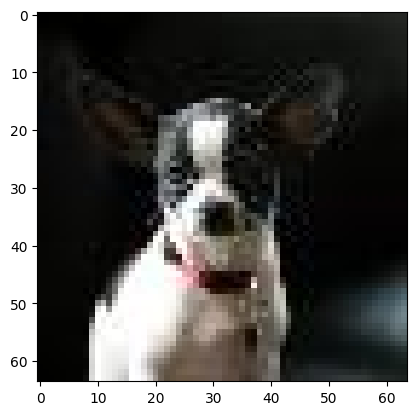

In [20]:
import matplotlib.pyplot as plt
image = imagenet_train[187*500+1]['image']
# show image
plt.imshow(image)

In [21]:
conversation = [{"role": "user", "content": processor.image_token + "\nDescribe the image"}]
prompt = processor.tokenizer.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)

def generate(prompt, image, **kwds):
    inp = processor(image, prompt, return_tensors="pt").to(model.device)
    streamer = transformers.TextStreamer(processor.tokenizer, True, skip_special_tokens=True)
    model.generate(**inp, max_new_tokens=256, streamer=streamer, eos_token_id=107, **kwds)

generate(prompt, image)


Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


The image features a small black and white dog sitting in the dark, with its ears perked up. The dog is wearing a red collar, and it appears to be looking at the camera. The dog is positioned in the center of the scene, with its head tilted to the side. The background is dark, creating a dramatic and moody atmosphere.


## Intervene on the activation functions of the Transformer

### Let's try different scales of intervention

In [28]:
# 27 - cat
# 4501 - feature in SAE encoding space that corresponds to friendly animals (particuarly dogs)
# Subtract this activation vector in the residual stream of the 12th block of the transformer
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(4501, -2))

The image features a close-up of a black and white dog with a red collar, standing in a dark room. The dog is wearing headphones, which are placed on its ears. The scene appears to be a black and white photograph, emphasizing the contrast between the dog and the dark background. The dog is the main focus of the image, with the headphones and the headphones alone being visible in the frame.


In [148]:
# 27 - cat
# 4501 - feature in SAE encoding space that corresponds to friendly animals (particuarly dogs)
# Subtract this activation vector in the residual stream of the 12th block of the transformer
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(4501, -3))

The image features a close-up of a person's hand holding a cell phone, with the focus on the back of the phone. The hand is holding the phone at a distance, and the image is in black and white. The person's hand is the main subject of the scene, and the background is dark, emphasizing the hand and the phone.

In the foreground, there is a person's hand holding a cell phone, and in the background, a person's face can be seen. The image captures a moment where the person is holding the phone, possibly taking a picture or viewing content on the screen.EOS


In [29]:
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(4501, -4))

The image features a close-up of a person's hands holding a cell phone, with the focus on the hands and the cell phone. The hands are holding the phone, and the image is in black and white. The cell phone is visible in the middle of the hands, with the hands spread out to the sides.

In the background, there is a person's face, but the main focus remains on the hands and the cell phone. The image captures a moment where the hands are holding the cell phone, possibly for a specific purpose or to display the content on the screen.


In [90]:
# A really large scale intervention produces gibberish output, which makes sense
# hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(4501, -20))

hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(4501, -6))

# becoming gibberish
# anything beyond this becomes completely incoherent

The image features a close-up of a person's hands holding a cell phone, with the focus on the hands and the surrounding area. The cell phone is in the middle of the hands, with the hands spread out to the sides. The image also includes a background that can be seen in the upper part of the cell phone, and the overall context suggests that the person is using the cell phone.EOS


In [ ]:
# A really large scale intervention produces gibberish output, which makes sense
# hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(4501, -20))

hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(4501, -7))

# becoming gibberish
# anything beyond this becomes completely incoherent

The image features a close-up of a person or a group of people, focusing on a specific aspect of the scene. The key point of the image is a person or a group of people, possibly a school or a group of people, with a specific aspect of the people or the underlying content of the people, such as a specific aspect of the people's content or a specific aspect of the people's content. The image is primarily focused on the underlying content, and the specific aspect of the people or the underlying content is the key point of the image. The image may be a part of a specific context or a specific point of the people's content, such as a specific aspect of the people's content, a specific aspect of the people's content, or a specific aspect of the people's content. The image may be a part of a specific context or a specific point of the people's content, such as a specific aspect of the people's content, a specific aspect of the people's content, or a specific aspect of the people's content. Th

### What happens when you intervene with a gibberish activation?

it seems that the noise is handled by the model, which is unexpected...
the noise is normally distributed, so maybe that's why

In [80]:
def gibberish_hook(magnitude):
    # encoded = torch.zeros(sae.cfg.d_sae, device=model.device)
    encoded = torch.randn(sae.cfg.d_sae, device=model.device) * magnitude
    bias = sae.decode(encoded)
    decoded = sae.decode(encoded) - bias
    def boost(value, hook):
        value += decoded
        return value
    return [(sae.cfg.hook_name, boost)]

In [58]:
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=gibberish_hook(6))

The image features a small black and white dog sitting in the dark, with its ears perked up. The dog is wearing a red collar, and it appears to be looking at the camera. The dog is positioned in the center of the scene, with its head tilted to the side. The background is dark, creating a dramatic and moody atmosphere.EOS


In [81]:
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=gibberish_hook(1000000000000))

The image features a small black and white dog sitting in the dark, with its ears perked up. The dog is wearing a red collar, and it appears to be looking at the camera. The dog is positioned in the center of the scene, with its head tilted to the side. The background is dark, creating a dramatic and moody atmosphere.EOS


In [125]:
def make_hook(idx, amt):
    encoded = torch.zeros(sae.cfg.d_sae, device=model.device)
    bias = sae.decode(encoded)
    encoded[idx] = amt
    decoded = sae.decode(encoded) - bias
    def boost(value, hook):
        value += decoded
        return value
    return [(sae.cfg.hook_name, boost)]

def crafted_gibberish_hook(magnitude):
    encoded = torch.zeros(sae.cfg.d_sae, device=model.device)
    bias = sae.decode(encoded)  
    encoded[4501] = magnitude  
    encoded[4502] = magnitude
    encoded[4503] = magnitude
    encoded[4504] = magnitude
    encoded[4505] = magnitude
    encoded[4506] = magnitude
    encoded[4507] = magnitude
    encoded[4508] = magnitude
    decoded = sae.decode(encoded) - bias
    def boost(value, hook):
        value += decoded
        return value
    return [(sae.cfg.hook_name, boost)]

In [ ]:
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=crafted_gibberish_hook(-2))

# gibberish intervention indeed produces gibberish output

In [100]:
def random_noise_hook(noise_scale=0.1):
    """
    Creates a hook that injects random Gaussian noise into the activations.
    
    Args:
        noise_scale: Standard deviation of the noise to add
        
    Returns:
        A hook that can be used with hooked_model.run_with_hooks()
    """
    def boost(value, hook):
        # Generate random noise with the same shape as the value tensor
        noise = torch.randn_like(value) * noise_scale
        # Add the noise to the value
        value += noise
        return value
    
    return [(sae.cfg.hook_name, boost)]

In [126]:
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=random_noise_hook(1.2))

The

 protagonist of the white dog in the middle of a single ziua-day, with acase of " "stand'w'thastly (sllllwell, two-sades-w-D

The dog is happily standing, and theD Dsterimim.Avez kawasaki, the dog'HHH-H, 00---own-up 00000o, of  ɵɵelementStart laiko. They onely onely onely onely onely blest-a- typelib-j-r-for.    .

20-000-11, 20-000-11102 100-000-2111111(1205 4477twimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimgtwimg

In [ ]:
# inject cat into dog
# 27 - cat
# 4501 - feature in SAE encoding space that corresponds to friendly animals (particuarly dogs)
# Subtract this activation vector in the residual stream of the 12th block of the transformer
hooked_generate(prompt, imagenet_train[187*500+1]["image"], fwd_hooks=make_hook(27, 3))

### Let's try a different image

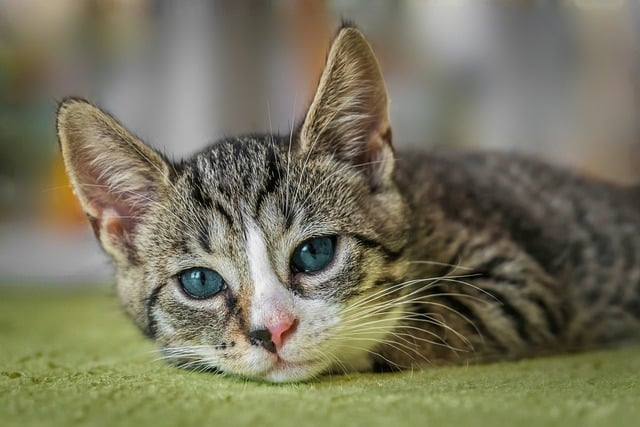

In [134]:
cat_image = Image.open("cat_image.png")
display(cat_image)

In [135]:
conversation = [{"role": "user", "content": processor.image_token + "\nDescribe the image"}]
prompt = processor.tokenizer.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)

def generate(prompt, image, **kwds):
    inp = processor(image, prompt, return_tensors="pt").to(model.device)
    streamer = transformers.TextStreamer(processor.tokenizer, True, skip_special_tokens=True)
    model.generate(**inp, max_new_tokens=256, streamer=streamer, eos_token_id=107, **kwds)

generate(prompt, cat_image)


The image features a small kitten with a blue eye, laying on a green surface. The kitten is looking up, possibly observing something in the distance. The kitten appears to be resting or sleeping, with its eyes closed. The kitten is positioned in the center of the image, occupying a significant portion of the frame.


In [172]:
acts = torch.zeros(sae.cfg.d_sae, device=model.device)
acts += sae.encode(run_model(prompt, cat_image, stop_at_layer=sae.cfg.hook_layer + 1)[1][sae.cfg.hook_name])[0, 586]

show_top(acts)

12287 references to animals and their interactions
787  contractions and their usage in speech or writing
4501 references to loyal companions, specifically dogs
11781  phrases related to parental guidance and involvement
15876  phrases and indicators related to legal or official declarations


In [147]:
hooked_generate(prompt, cat_image, fwd_hooks=make_hook(4501, -3))

The image features a close-up of a person's hand holding a small child's face, with the focus on the face of a person. The person is holding a young child, and the image captures the details of the face, including the eyes and the mouth.

In the background, there is a green surface, possibly a table or a wall, which provides a contrasting background for the image. The overall composition of the image emphasizes the details of the face and the person's hand, creating a clear and focused view of the subject.EOS


it's interesting that the model removed the cat from the description but still recognizes the green background